### Task

Optimise team picks for footballsurvivor.co.uk. 
Game rules: pick a Premier League team each week that you expect to win their match. Start the season with 10 lives :
* If team wins: drop 0 lives
* If team draws: drop 1 life
* If team loses: drop 2 lives

**You can only pick each team once during the course of the season**

If you run out of lives, you lose. If you survive, the winner is the person with the most remaining lives.

### Approach
Apply linear sum assignment (a.k.a Hungarian algorithm) to select n teams over k weeks, such that a single team is assigned to exactly one week.

The assignment will be made based on maximizing some value. In this case we will use a team's  weekly win probability calculated by fivethirtyeight.com 

In [1]:
from __future__ import print_function
import pandas as pd
import requests 
from collections import defaultdict
from scipy.optimize import linear_sum_assignment
import json 
from lxml import html
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
%matplotlib inline 

### [1] fivethirtyeight.com data
The first step is to download and parse data from fivethirtyeight.com (which we will refer to as **fte**) to get a modelled probability of a team winning a match against a specific opponent, based on their recent performances (and other factors). 

The sum of these probabilities will be the value we are trying to maximize when we make our team picks.

The **fte** data in nicely packaged in a json api which we will download and parse into a dataframe. 

In [2]:
def get_fte_data(year):
    """download and parse fivethirtyeight.com predictions for a single year"""
    fte_url = 'https://projects.fivethirtyeight.com/soccer-predictions/forecasts/{}_premier-league_matches.json'.format(year)
    fte_json = requests.get(fte_url).json()
    
    fte_records = []
    for match in fte_json:
        fte_records.append({
            'team': match['team1_code'],
            'p_win': match['prob1'],
            'opp': match['team2_code'], 
            'loc': 'home'
           })
        fte_records.append({
            'team': match['team2_code'],
            'p_win': match['prob2'],
            'opp': match['team1_code'],
            'loc': 'away'
           })
        
    return pd.DataFrame.from_dict(fte_records)

In [3]:
df_fte = get_fte_data(2017)
df_fte.head()

,loc,opp,p_win,team
0,home,LEI,0.6430,ARS
1,away,ARS,0.1563,LEI
2,home,LIV,0.2193,WAT
3,away,WAT,0.5384,LIV
4,home,BRN,0.7184,CHE


### [2] footballsurvivor.co.uk data
Now that we have the probability of a team winning a particular match, we need to know which "gameweek"   that match belongs to, as our aim is to pick a single team for each gameweek. A gameweek is defined as a round of matches in which every team plays exactly once. 

To get this data we need to scrape footballsurvivor.co.uk (**fs**), which is slightly more convoluted as we first need to login to the website, whilst the data itself is embedded in the html.

We create a `requests` session object to persist our authentication parameters after logging in, then use xpath to extract the gameweek definitions from the html.

We will also return a boolean indicating whether a team was picked in that gameweek. At the start of the season this will be False for all records, but will be useful later on if we want to recalculate our picks, as we can easily exclude teams which have already been picked.

In [4]:
def fs_session_login(credentials):
    session = requests.Session()
    login_url = 'https://footballsurvivor.co.uk/users/sign_in'
    authenticity_token = html.fromstring(session.get(login_url).content).xpath('//input[@name="authenticity_token"]/@value')[0]
    values = {
        'authenticity_token': authenticity_token,
        'user[email]': "starhammer@live.co.uk" ,
        'user[password]': "footballsurvivor",
        'commit': "Login"
    }
    response = session.post(login_url, data=values)
    assert response.url != login_url, 'login unsuccessful, check credentials'
    return session


def get_fs_data(fs_session, league_url):
    """
    
    """
    html_bytes = fs_session.get(league_url).content
    html_tree = html.fromstring(html_bytes)
    
    fs_records = [] 
    for gameweek_header in html_tree.xpath('//h2[@id]'):
        gameweek_id = gameweek_header.attrib['id'].split('-')[-1]
        gameweek_fixtures = gameweek_header.getnext()
        for fixture in gameweek_fixtures.xpath('.//tr'):
            home_team = fixture.xpath('./td[1]/span[1]/text()')[0].strip('\n')
            away_team = fixture.xpath('./td[3]/span[2]/text()')[0].strip('\n')
            fs_records.append({
                'gameweek': gameweek_id, 
                'team': home_team, 
                'opp': away_team, 
                'picked': 'team-picked' in fixture.xpath('./td[1]')[0].attrib['class'], 
                'loc': 'home'
                })
            fs_records.append({
                'gameweek': gameweek_id, 
                'team': away_team, 
                'opp': home_team, 
                'picked': 'team-picked' in fixture.xpath('./td[3]')[0].attrib['class'], 
                'loc': 'away'
                })
    return pd.DataFrame.from_dict(fs_records) 

In [5]:
fs_session = fs_session_login('x')

league_url = 'https://footballsurvivor.co.uk/leagues/geo_punters_winner_takes_all/entries/70392/fixtures' 

df_fs = get_fs_data(fs_session, league_url)
df_fs.head() 

,gameweek,loc,opp,picked,team
0,22,home,Bournemouth,False,Brighton
1,22,away,Brighton,False,Bournemouth
2,22,home,Liverpool,False,Burnley
3,22,away,Burnley,False,Liverpool
4,22,home,Newcastle,False,Stoke City


### [3] Merging dataframes 
We now have a dataframe for each data source, so the next step is to merge them into a single dataframe. Whilst each dataframe has the same record unique "key" ('team', 'opp', 'loc'), the format of the team names for **fte** data is different to **fs**.

We will firstly map the **fs** team names to their **fte** equivalents (as they are less verbose), then merge the dataframes. 

In [6]:
fs_to_fte = {
    'Arsenal': 'ARS', 
    'Bournemouth': 'BOU', 
    'Brighton': 'BHA', 
    'Burnley': 'BRN', 
    'Chelsea': 'CHE', 
    'Everton': 'EVE', 
    'Huddersfield': 'HUD',
    'Leicester': 'LEI', 
    'Liverpool': 'LIV', 
    'Man United': 'MAN', 
    'Man City': 'MNC', 
    'Newcastle': 'NEW', 
    'Palace': 'CRY',
    'Southampton': 'SOU', 
    'Spurs': 'TOT', 
    'Stoke City': 'STK', 
    'Swansea': 'SWA', 
    'Watford': 'WAT', 
    'West Brom': 'WBA', 
    'West Ham': 'WHU' 
   }

df_fs.loc[:, ['team','opp']] = df_fs[['team','opp']].applymap(fs_to_fte.get)

In [7]:
df_merged = df_fte.merge(df_fs, on=('team','opp','loc'))
df_merged.head()

,loc,opp,p_win,team,gameweek,picked
0,home,BOU,0.3902,BHA,22,False
1,away,BHA,0.3058,BOU,22,False
2,home,LIV,0.1736,BRN,22,False
3,away,BRN,0.5934,LIV,22,False
4,home,NEW,0.4679,STK,22,False


### [4] Reshape to probability matrix 

Currently we have a long-form dataframe with one row per team/gameweek combination. We need to reshape it into a wide "matrix" with one row per gameweek and one column per team as this is the format required by the the `scipy` function we use to optimise our picks. 

The values of the matrix will be the win probability of that team/gameweek combination. 

In [8]:
df_prob_matrix = df_merged.set_index(['gameweek', 'team'])['p_win'].unstack()
df_prob_matrix.iloc[:5,:5]

team,ARS,BHA,BOU,BRN,CHE
gameweek,,,,,
22,0.4013,0.3902,0.3058,0.1736,0.3500
23,0.6335,0.2139,0.1723,0.2300,0.7571
24,0.6763,0.1214,0.2977,0.2433,0.6643
25,0.6599,0.1916,0.0464,0.3216,0.8298
26,0.7707,0.3922,0.4832,0.1269,0.6454


### [5] Optimise picks
The final step is to apply `scipy.linear_sum_assigment` to our matrix which selects exactly one element from each row and each column, such that the sum of the selected elements are maximized.

To recap, the footballsurvivor competition requires us to pick a single team for each gamweek, without repeating any team. As better teams will consistently have a higher win probability across all gameweeks, one approach could be to pick teams in order of probability, with the most likely winners picked first. However, once we have exhausted the all stronger picks, we will have fewer gameweeks left in which to try and pick a winning match for the weaker teams.

The motivation for our chosen approach is that by trying to maximize the probability of winning for all teams, we will (on average) have a better chance of picking a winner each time.

In [9]:
def optimise_picks(df, value_label):
    """ 
    :param df: input DataFrame containing values to be maximized
    :param value_label: String describing df values
    :returns: output DataFrame with one row corresponding to each selected value
    """
    cost_matrix = df.values * -1 # taking inverse costs as we want to maximise
    row_ids, col_ids = linear_sum_assignment(cost_matrix) 
    d = defaultdict(list)
    
    for i in range(min(cost_matrix.shape)):
        row_idx = row_ids[i] 
        col_idx = col_ids[i]
        d[df.index.name].append(df.index[row_idx])
        d[df.columns.name].append(df.columns[col_idx])
        d[value_label].append(cost_matrix[row_idx, col_idx] * -1) 
    return pd.DataFrame(d)

In [10]:
df_picks = optimise_picks(df_prob_matrix, 'p_win')
df_picks.head()

,gameweek,p_win,team
0,22,0.5801,LEI
1,23,0.4668,NEW
2,24,0.4846,STK
3,25,0.5252,SOU
4,26,0.8096,MAN


We now have out optimised picks!

Plotting the entire probability matrix, with our selected picks highlighted

In [11]:
def plot_picks_heatmap(df_prob_matrix, df_picks, plot_size=(None, None)):
    """
    :param df_prob_matrix: DataFrame with rows as gameweeks, columns as teams and values as win probability 
    :param df_picks: DataFrame with team and gameweek columns (one row per pick) 
    :param plot_size: tuple containing plot dimensions
    """
    plt.rcParams['figure.figsize'] = plot_size
    ax = sns.heatmap(df_prob_matrix, cmap=sns.color_palette("Blues", n_colors=20), annot=True, cbar=False)
    for _, row in df_picks.iterrows():
        row_num = df_prob_matrix.index.get_loc(row['gameweek'])
        col_num = df_prob_matrix.columns.get_loc(row['team']) 
        ax.add_patch(Rectangle((col_num, row_num), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.show() 

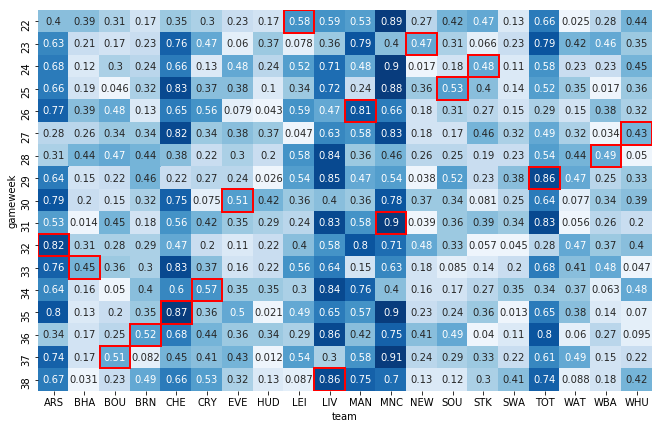

In [12]:
plot_picks_heatmap(df_prob_matrix, df_picks, plot_size=(11,7))

Notice that some teams have not been picked at all, this is because the footballsurvivor league used in this example was started towards the end of the season, and so their are not enough gameweeks left to require all team to be picked.

This is not a problem as the algorithm automatically handles a non-square matrix by only picking the teams which maximize the objective (sum of probabilities). 

Calculating the average probability for our optimised picks:

In [13]:
df_picks.p_win.mean() 

0.6268705882352941

### [6] Filter picks (optional)
Before finding our optimised picks, we can remove specific teams/gameweeks. Why would we want to do this? 

Firstly, we may want to recalculate our optimal picks after the season has started. This is because the modelled probabilities will likely be more accurate later in the season, as more data becomes available. For example, before the start of the season the model can only be built on data from previous seasons. As a team will often change personnel between seasons this suggests that recent, same season data will be more reliable. 

Secondly, and perhaps more importantly, we have ignored an important feature of the footballsurvivor game: you have a finite number of "lives" which will likely run out before the end of the competition. This means that later picks may become worthless, and our current strategy may result in us assigning some of our best teams to our final gameweeks. 

Therefore we want a mechanism for assigning weight to earlier picks, as we are more confident that these will be utilised. One possible solution is a sliding window, with a length proportional to the number of lives you have remaining. For example you might want to only make picks for gameweek 1-10 whilst you have 10 lives remaining. If you are successful with your first pick   and keep all your lives, you make new optimised picks for gameweek 2-11. If you are unsuccessful and lose a life you may want to reduce your window to only gameweek 2-10 as you are now less likely to survive until the end of the season.

Another advantage of making picks over a shorter window is that the win probabilities are updated after each gameweek, and so predictions made on gameweeks which are closer in time to when the prediction was made are likely be more reliable. 

Whilst I have had past success with this approach, it is based on heuristics and the choice of window is rather arbitrary. A more robust approach would be to determine an optimal window size, which I will investigate in future. Whilst there is currently only one season of **fte** predictions available to carry out such analysis, we could sample the available matches to simulate other seasons.

In [14]:
def filter_team_gameweek(df, teams=[], gameweeks=[]):
    """
    :param df: input DataFrame  
    :param teams: list of teams to exclude from df  
    :param gw: list of gameweeks to exclude from df 
    :rtype: DataFrame
    """
    print("excluding teams:", teams) 
    print("excluding gameweeks:", gameweeks) 
    return df[~(df.team.isin(teams)) & ~(df.gameweek.isin(gameweeks))]  